<a href="https://colab.research.google.com/github/snekumar/AD_Prediction/blob/main/3DCNN/sample_train_and_test_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.8/188.8 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.8/218.8 kB 23.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.7 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=c51209d0fa5d32dd5aecb5513b51870a5e28955469a0e630909c9d7b943e2393
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
import os
import glob
import random
import tempfile

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import cv2
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import wandb
from ipywidgets import IntSlider, interact
# from kaggle_secrets import UserSecretsClient
from matplotlib import animation, rc
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.path import Path
from scipy import ndimage
from scipy.ndimage import zoom
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import class_weight
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import (BatchNormalization, Conv3D, Dense,
                                     Dropout, GlobalAveragePooling3D,
                                     Input, MaxPool3D, Rescaling)
from tensorflow.keras.optimizers import Adam
from wandb.keras import WandbCallback

In [ ]:
seed = 27

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
from getpass import getpass


In [ ]:
import wandb
# Login to WandB
wandb.login()



<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
run = wandb.init(
    project='project3dc',
    entity='sneha-17ec',
    id='28-mw-3D-ResCSN-FT6-cw-AD-CN',
)


wandb: Currently logged in as: sneha-17ec. Use `wandb login --relogin` to force relogin


In [ ]:
wandb.config = {
    'learning_rate': 1e-3,
    'min_learning_rate': 1e-5,
    'epochs': 100,
    'batch_size': 8,
    'test_batch_size': 1,
    'img_size': 128,
    'depth': 64,
    'n_classes': 2
}

config = wandb.config

Data load and Preprocessing



In [ ]:
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    volume = (volume - np.min(volume)) / (np.max(volume) - np.min(volume))
    return volume.astype('float32')


def resize_volume(img, desired_width=128, desired_height=128, desired_depth=64):
    """Resize the volume"""
    # Compute zoom factors
    width_factor = desired_width / img.shape[0]
    height_factor = desired_height / img.shape[1]
    depth_factor = desired_depth / img.shape[-1]
    # Rotate volume by 90 degrees
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize the volume using spline interpolated zoom (SIZ)
    img = zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height, and depth
    volume = resize_volume(
        volume, 128, 128, 64
    )
    return volume



 Class Distribution

In [ ]:
ad_paths = [
    os.path.join(os.getcwd(), '/content/drive/MyDrive/datas/AD', x)
    for x in os.listdir('/content/drive/MyDrive/datas/AD')
]

mci_paths = [
    os.path.join(os.getcwd(), '/content/drive/MyDrive/datas/MCI', x)
    for x in os.listdir('/content/drive/MyDrive/datas/MCI')
]

cn_paths = [
    os.path.join(os.getcwd(), '/content/drive/MyDrive/datas/CN', x)
    for x in os.listdir('/content/drive/MyDrive/datas/CN')
]

print(f'Number of AD images: {len(ad_paths)}')
print(f'Number of MCI images: {len(mci_paths)}')
print(f'Number of CN images: {len(cn_paths)}')

Number of AD images: 32
Number of MCI images: 120
Number of CN images: 60


Build Train

In [ ]:
ad_labels = np.array([0 for _ in range(len(ad_paths))])
mci_labels = np.array([0 for _ in range(len(mci_paths))])
# ad_labels = np.array([1 for _ in range(len(ad_paths))])
cn_labels = np.array([1 for _ in range(len(cn_paths))])
CLASS_NAMES = ['AD','MCI', 'CN']

# labels = np.concatenate((np.concatenate((mci_labels, ad_labels), axis=0), cn_labels), axis=0)
labels = np.concatenate((mci_labels, cn_labels), axis=0)
# paths = np.concatenate((np.concatenate((mci_paths, ad_paths), axis=0), nc_paths), axis=0)
paths = np.concatenate((mci_paths, cn_paths), axis=0)

In [ ]:
train_indices, test_indices = next(
    StratifiedShuffleSplit(1, train_size=0.8, random_state=seed).split(
        paths, labels
    )
)

tmp_labels = [labels[idx] for idx in train_indices]
tmp_paths = [paths[idx] for idx in train_indices]

tmp_train_indices, tmp_val_indices = next(
    StratifiedShuffleSplit(1, train_size=0.8, random_state=seed).split(
        tmp_paths, tmp_labels
    )
)

tmp_train_paths = [tmp_paths[idx] for idx in tmp_train_indices]
tmp_val_paths = [tmp_paths[idx] for idx in tmp_val_indices]

train_indices = [paths.tolist().index(path) for path in tmp_train_paths]
val_indices = [paths.tolist().index(path) for path in tmp_val_paths]

# Check if there are no common indices
assert bool(set(train_indices) & set(val_indices)) is False
assert bool(set(train_indices) & set(test_indices)) is False
assert bool(set(val_indices) & set(test_indices)) is False

print(
    'Number of samples:\n'
    f'train: {len(train_indices)}\n'
    f'validation: {len(val_indices)}\n'
    f'test: {len(test_indices)}'
)

Number of samples:
train: 115
validation: 29
test: 36


In [ ]:
def random_rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume

In [ ]:
import os

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, indices, paths, labels, batch_size=4, dim=(128, 128, 64),
                 n_classes=2, shuffle=True, transform=None):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.paths = paths
        self.labels = labels
        self.indices = indices
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.transform = transform
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        indices_temp = [self.indices[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(indices_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.indices))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indices_temp):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, 1))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(indices_temp):
            # Store sample
            try:
                volume = process_scan(self.paths[ID])

            except FileNotFoundError:

                continue

            if self.transform is not None:
                volume = self.transform(volume)
            X[i,] = np.expand_dims(volume, axis=3)

            # Store class
            y[i] = self.labels[ID]

        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)


In [ ]:
train_indices, test_indices = next(
    StratifiedShuffleSplit(1, train_size=0.8, random_state=seed).split(
        paths, labels
    )
)

tmp_labels = [labels[idx] for idx in train_indices]
tmp_paths = [paths[idx] for idx in train_indices]

tmp_train_indices, tmp_val_indices = next(
    StratifiedShuffleSplit(1, train_size=0.8, random_state=seed).split(
        tmp_paths, tmp_labels
    )
)

tmp_train_paths = [tmp_paths[idx] for idx in tmp_train_indices]
tmp_val_paths = [tmp_paths[idx] for idx in tmp_val_indices]

train_indices = [paths.tolist().index(path) for path in tmp_train_paths]
val_indices = [paths.tolist().index(path) for path in tmp_val_paths]

# Check if there are no common indices
assert bool(set(train_indices) & set(val_indices)) is False
assert bool(set(train_indices) & set(test_indices)) is False
assert bool(set(val_indices) & set(test_indices)) is False

print(
    'Number of samples:\n'
    f'train: {len(train_indices)} ({round(float(len(train_indices)) / float(len(labels)) * 100.0)}% of the dataset)\n'
    f'validation: {len(val_indices)} ({round(float(len(val_indices)) / float(len(labels)) * 100.0)}% of the dataset)\n'
    f'test: {len(test_indices)} ({round(float(len(test_indices)) / float(len(labels)) * 100.0)}% of the dataset)'
)

Number of samples:
train: 115 (64% of the dataset)
validation: 29 (16% of the dataset)
test: 36 (20% of the dataset)


In [ ]:
def random_rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume

In [ ]:
training_generator = DataGenerator(
    train_indices,
    paths,
    labels,
    batch_size=config['batch_size'],
    dim=(config['img_size'], config['img_size'], config['depth']),
    shuffle=True,
    transform=random_rotate,
)

validation_generator = DataGenerator(
    val_indices,
    paths,
    labels,
    batch_size=config['batch_size'],
    dim=(config['img_size'], config['img_size'], config['depth']),
    shuffle=True,
)

test_generator = DataGenerator(
    test_indices,
    paths,
    labels,
    batch_size=config['test_batch_size'],
    dim=(config['img_size'], config['img_size'], config['depth']),
    shuffle=False,
)

In [ ]:
validation_generator

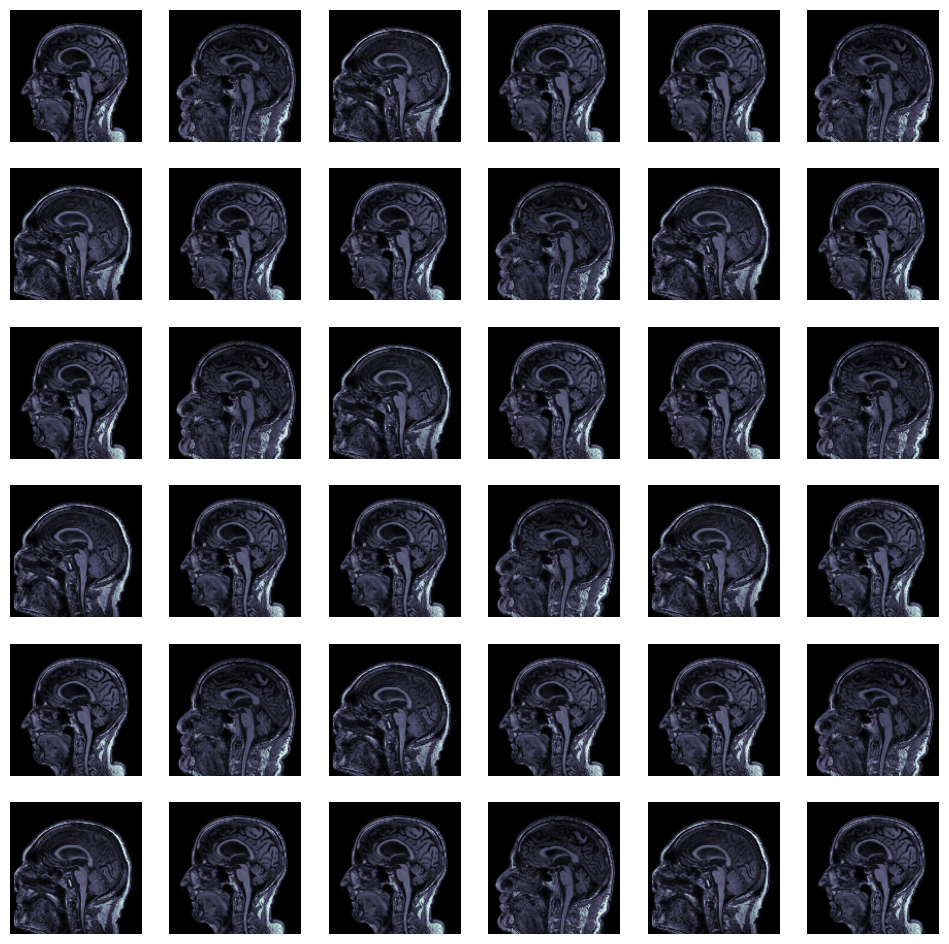

In [ ]:
def plot_ct_scan_images(generator, num_images=4, num_rotations=2, grid_size=(6, 6)):
    # Get a batch of images from the generator
    batch_x, _ = generator.__getitem__(0)  # Ignore batch_y (labels)

    # Create a new figure for the grid
    plt.figure(figsize=(12, 12))

    for i in range(grid_size[0] * grid_size[1]):
        plt.subplot(grid_size[0], grid_size[1], i + 1)

        # Calculate the index of the image in the batch
        image_index = i % num_images

        # Rotate the image multiple times
        rotated_image = batch_x[image_index]
        for _ in range(num_rotations):
            rotated_image = np.rot90(rotated_image)

        plt.imshow(np.squeeze(rotated_image[:, :, generator.dim[2] // 2]), cmap='bone')
        plt.axis('off')

    plt.show()

# Plot images from the test_generator in a 6x6 grid with each image rotated three times
plot_ct_scan_images(validation_generator, num_images=4, num_rotations=3, grid_size=(6, 6))


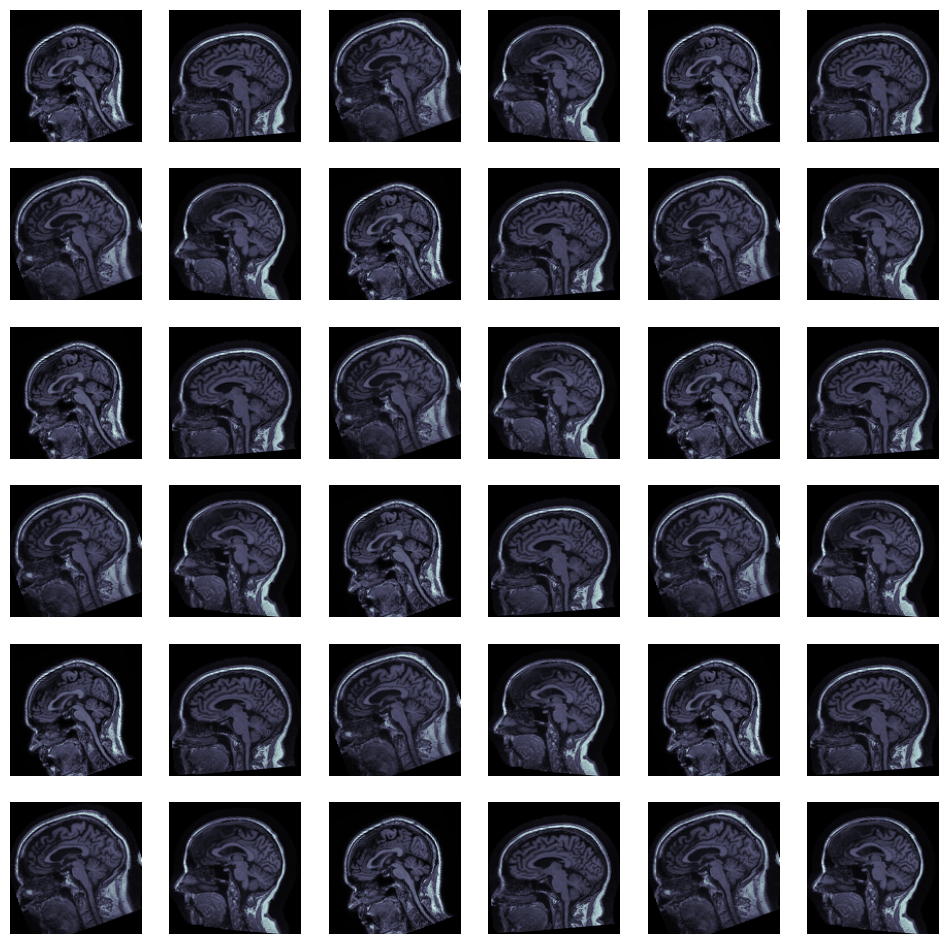

In [ ]:
def plot_ct_scan_images(generator, num_images=4, num_rotations=2, grid_size=(6, 6)):
    # Get a batch of images from the generator
    batch_x, _ = generator.__getitem__(0)  # Ignore batch_y (labels)

    # Create a new figure for the grid
    plt.figure(figsize=(12, 12))

    for i in range(grid_size[0] * grid_size[1]):
        plt.subplot(grid_size[0], grid_size[1], i + 1)

        # Calculate the index of the image in the batch
        image_index = i % num_images

        # Rotate the image multiple times
        rotated_image = batch_x[image_index]
        for _ in range(num_rotations):
            rotated_image = np.rot90(rotated_image)

        plt.imshow(np.squeeze(rotated_image[:, :, generator.dim[2] // 2]), cmap='bone')
        plt.axis('off')

    plt.show()

# Plot images from the training generator in a 6x6 grid with each image rotated three times
plot_ct_scan_images(training_generator, num_images=4, num_rotations=3, grid_size=(6, 6))


Dimensions of the CT scan are: (128, 128, 64, 1)


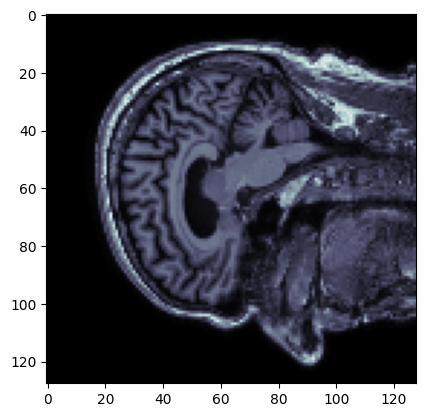

In [ ]:
images = process_scan(paths[0])
# images = resize_volume(images, desired_width=128, desired_height=128, desired_depth=64)
images = np.expand_dims(images, axis=3)
images = np.expand_dims(images, axis=0)
image = images[0]

print('Dimensions of the CT scan are:', image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap='bone')


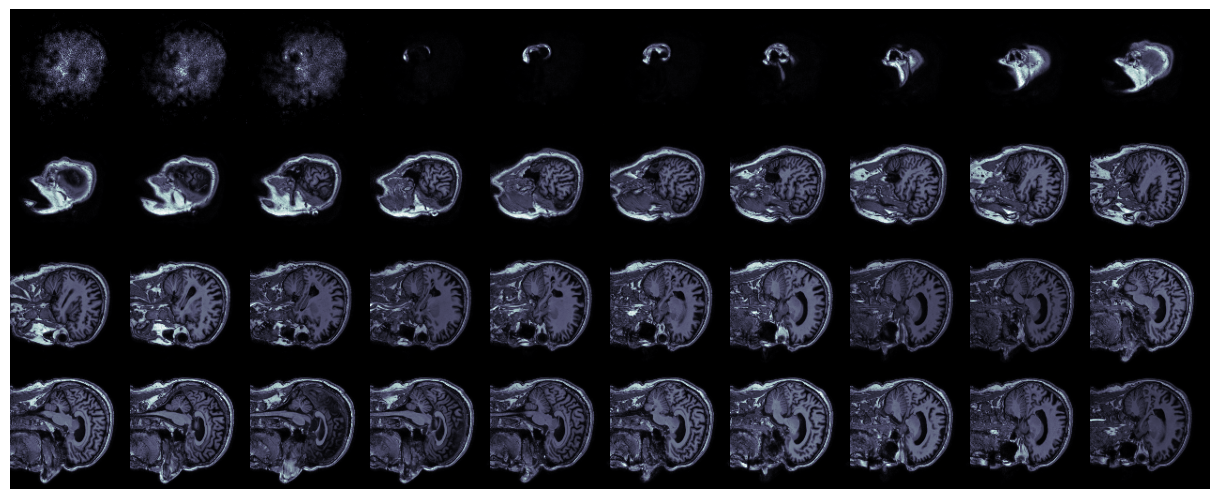

In [ ]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    _, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={'height_ratios': heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap='bone')
            axarr[i, j].axis('off')
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 40 slices of the CT scan.
plot_slices(4, 10, 128, 128, image[:, :, :40])

In [ ]:
class Conv2Plus1D(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, padding, **kwargs):
        """
            A sequence of convolutional layers that first apply the convolution operation
            over the spatial dimensions, and then the temporal dimension.
        """
        super().__init__(**kwargs)
        self.seq = tf.keras.Sequential([
            # Spatial decomposition
            Conv3D(filters=filters,
                   kernel_size=(1, kernel_size[1], kernel_size[2]),
                   padding=padding),
            # Temporal decomposition
            Conv3D(filters=filters,
                   kernel_size=(kernel_size[0], 1, 1),
                   padding=padding)
            ])
        self.filters = filters
        self.kernel_size = kernel_size
        self.padding = padding

    def call(self, x):
        return self.seq(x)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'padding': self.padding,
        })
        return config


class ResidualMain(tf.keras.layers.Layer):
    """
        Residual block of the model with convolution, layer normalization,
        and the activation function, ReLU.
    """
    def __init__(self, filters, kernel_size, **kwargs):
        super().__init__(**kwargs)
        self.seq = tf.keras.Sequential([
            Conv2Plus1D(filters=filters,
                        kernel_size=kernel_size,
                        padding='same'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.ReLU(),
            Conv2Plus1D(filters=filters,
                        kernel_size=kernel_size,
                        padding='same'),
            tf.keras.layers.LayerNormalization()
        ])
        self.filters = filters
        self.kernel_size = kernel_size

    def call(self, x):
        return self.seq(x)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'filters': self.filters,
            'kernel_size': self.kernel_size,
        })
        return config


class Project(tf.keras.layers.Layer):
    """
        Project certain dimensions of the tensor as the data is passed
        through different sized filters and downsampled.
    """
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(units),
            tf.keras.layers.LayerNormalization()
        ])
        self.units = units

    def call(self, x):
        return self.seq(x)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'units': self.units,
        })
        return config


def add_residual_block(input, filters, kernel_size):
    """
        Add residual blocks to the model. If the last dimensions of the input data
        and filter size does not match, project it such that last dimension matches.
    """
    out = ResidualMain(filters, kernel_size)(input)

    res = input
    # Using the Keras functional APIs, project the last dimension of the tensor to
    # match the new filter size
    if out.shape[-1] != input.shape[-1]:
        res = Project(out.shape[-1])(res)

    return tf.keras.layers.add([res, out])

In [ ]:
def add_regularization(model, regularizer=tf.keras.regularizers.l2(1e-7)):
    if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
        print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
        return model

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
                setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # load the model from the config
    model = tf.keras.models.model_from_json(model_json,
                                            custom_objects={
                                                'Project': Project,
                                                'ResidualMain': ResidualMain,
                                                'Conv2Plus1D': Conv2Plus1D,
                                            })

    # Reload the model weights
    model.load_weights(tmp_weights_path, by_name=True)
    return model

In [ ]:
def get_model(height=128, width=128, depth=64):
    """Build a 3D convolutional neural network model."""
    inputs = Input((height, width, depth, 1))

    x = add_residual_block(inputs, filters=16, kernel_size=(3, 3, 3))
    x = MaxPool3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same')(x)
    x = BatchNormalization()(x)

    x = add_residual_block(x, filters=32, kernel_size=(3, 3, 3))
    x = MaxPool3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same')(x)
    x = BatchNormalization()(x)

    x = add_residual_block(x, filters=64, kernel_size=(3, 3, 3))
    x = MaxPool3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same')(x)
    x = BatchNormalization()(x)

    x = add_residual_block(x, filters=128, kernel_size=(3, 3, 3))
    x = MaxPool3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same')(x)
    x = BatchNormalization()(x)

    x = GlobalAveragePooling3D()(x)

    x = Dense(units=128, activation='relu')(x)
    x = Dropout(0.7)(x)

    x = Dense(units=64, activation='relu')(x)
    x = Dropout(0.7)(x)

    outputs = Dense(units=config['n_classes'], activation='softmax')(x)

    return Model(inputs, outputs, name='2-1D-CNN2')

In [ ]:
# Build model.
model = get_model(height=config['img_size'],
                  width=config['img_size'], depth=config['depth'])


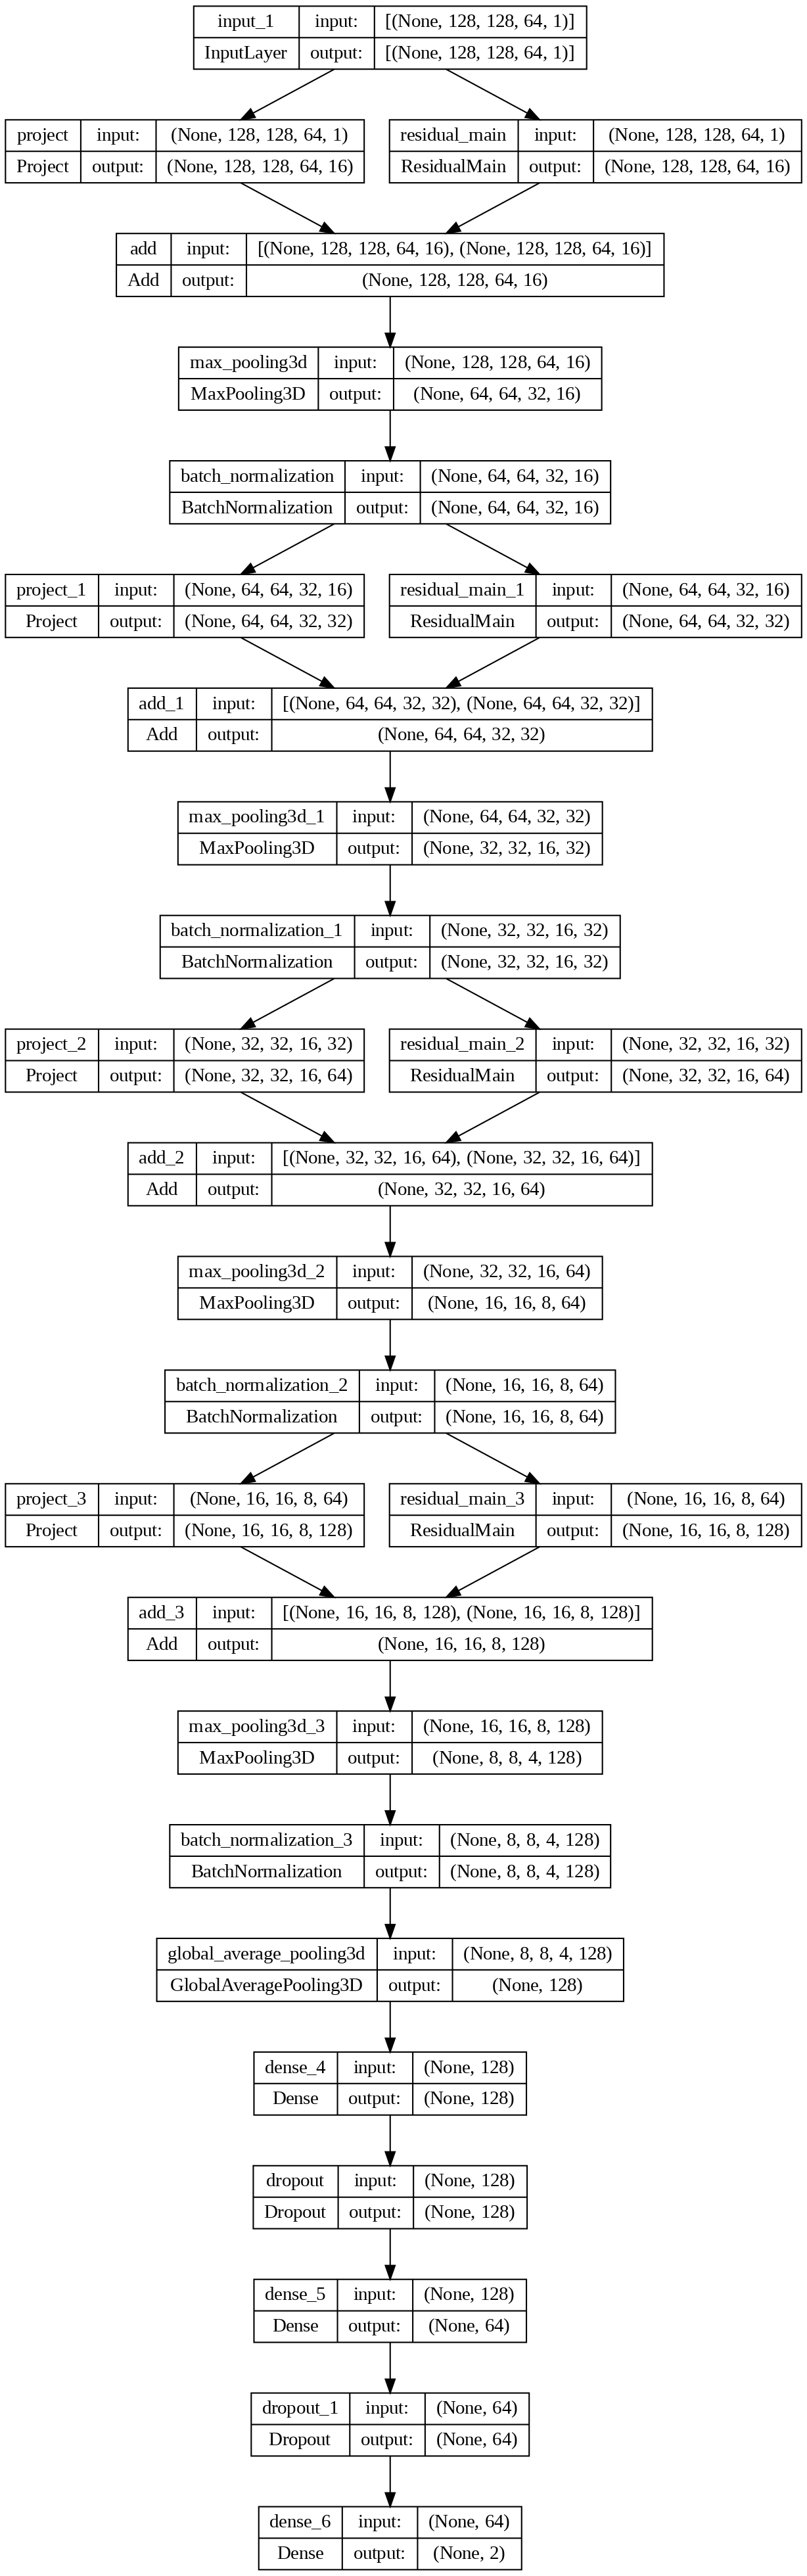

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, MaxPool3D, BatchNormalization, GlobalAveragePooling3D, Dropout
import os
import tempfile


# Plot the model architecture
tf.keras.utils.plot_model(model, show_shapes=True, dpi=150)


In [ ]:
# import os
# import getpass
# import wandb

# # Set the environment variables
# os.environ['WANDB_ENTITY'] = 'sneha-17ec'
# os.environ['WANDB_PROJECT'] = 'project3dc'

# # Prompt for the API key
# api_key = getpass.getpass('Enter your W&B API key: ')

# # Log in to Weights & Biases
# wandb.login(key=api_key)

# # Initialize the run
# run = wandb.init(
#     name='28-mw-3D-ResCSN-FT6-cw-AD-CN',
#     project=os.environ['WANDB_PROJECT'],
#     entity=os.environ['WANDB_ENTITY'],
#     id='28-mw-3D-ResCSN-FT6-cw-AD-CN'
# )

In [ ]:
model.save_weights('model-best.h5')


In [ ]:
model

In [ ]:
model = add_regularization(model, regularizer=tf.keras.regularizers.l2(1e-4))
model.load_weights('model-best.h5')
model.summary()


Model: "2-1D-CNN2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 6  0           []                               
                                4, 1)]                                                            
                                                                                                  
 project (Project)              (None, 128, 128, 64  64          ['input_1[0][0]']                
                                , 16)                                                             
                                                                                                  
 residual_main (ResidualMain)   (None, 128, 128, 64  4112        ['input_1[0][0]']                
                                , 16)                                                     

In [ ]:
train_labels = [labels[idx] for idx in train_indices]
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', # balanced for computing weights based on class count
    classes=np.unique(train_labels),
    y=train_labels,
)
class_weights = dict(zip(np.unique(labels), class_weights))
print(class_weights)

{0: 0.7467532467532467, 1: 1.513157894736842}


In [ ]:
# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=config['learning_rate']),
    metrics=['acc'],
)

# Train the model, doing validation at the end of each epoch
model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=config['epochs'],
    class_weight=class_weights,
    verbose=2,
    callbacks=[
        ModelCheckpoint('best.h5', save_best_only=True, monitor='val_loss', mode='min'),
        ReduceLROnPlateau(
            monitor='val_loss',
            mode='min',
            patience=7,
            factor=0.5,
            min_lr=config['min_learning_rate'],
        ),
        EarlyStopping(monitor='val_loss', mode='min',
                      patience=config['epochs'], restore_best_weights=True),
        WandbCallback(mode='min'),
    ],
    workers=6
)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/100
66/66 - 227s - loss: 0.1723 - acc: 0.9489 - val_loss: 1.7022 - val_acc: 0.6016
Epoch 2/100
66/66 - 211s - loss: 0.1838 - acc: 0.9432 - val_loss: 16.1324 - val_acc: 0.3203
Epoch 3/100
66/66 - 211s - loss: 0.2915 - acc: 0.9072 - val_loss: 0.9951 - val_acc: 0.8047
Epoch 4/100
66/66 - 212s - loss: 0.1571 - acc: 0.9489 - val_loss: 1.8725 - val_acc: 0.7422
Epoch 5/100
66/66 - 213s - loss: 0.1658 - acc: 0.9451 - val_loss: 0.9304 - val_acc: 0.7891
Epoch 6/100
66/66 - 215s - loss: 0.1429 - acc: 0.9621 - val_loss: 8.4826 - val_acc: 0.3281
Epoch 7/100
66/66 - 220s - loss: 0.1598 - acc: 0.9470 - val_loss: 1.3930 - val_acc: 0.7969
Epoch 8/100
66/66 - 214s - loss: 0.1290 - acc: 0.9697 - val_loss: 8.8552 - val_acc: 0.3203
Epoch 9/100
66/66 - 212s - loss: 0.1583 - acc: 0.9640 - val_loss: 0.5820 - val_acc: 0.8516
Epoch 10/100
66/66 - 212s - loss: 0.1808 - acc: 0.9318 - val_loss: 2.8511 - val_acc: 0.5469
Epoch 11/100
66/66 - 212s - loss: 0.2087 - acc: 0.9280 - val_loss: 10.4151 - val_acc: 0.

wandb: Network error (ReadTimeout), entering retry loop.


66/66 - 210s - loss: 0.0401 - acc: 0.9962 - val_loss: 0.3347 - val_acc: 0.9141
Epoch 74/100
66/66 - 208s - loss: 0.0448 - acc: 0.9943 - val_loss: 0.3965 - val_acc: 0.9141
Epoch 75/100
66/66 - 211s - loss: 0.0502 - acc: 0.9924 - val_loss: 0.4301 - val_acc: 0.9062
Epoch 76/100
66/66 - 207s - loss: 0.0572 - acc: 0.9886 - val_loss: 0.4040 - val_acc: 0.9062
Epoch 77/100
66/66 - 210s - loss: 0.0804 - acc: 0.9830 - val_loss: 0.3709 - val_acc: 0.9062
Epoch 78/100
66/66 - 208s - loss: 0.0734 - acc: 0.9811 - val_loss: 0.4368 - val_acc: 0.9062
Epoch 79/100
66/66 - 207s - loss: 0.0991 - acc: 0.9848 - val_loss: 0.3505 - val_acc: 0.9141
Epoch 80/100
66/66 - 207s - loss: 0.0397 - acc: 0.9924 - val_loss: 0.3654 - val_acc: 0.9141
Epoch 81/100
66/66 - 208s - loss: 0.0356 - acc: 0.9981 - val_loss: 0.4823 - val_acc: 0.8984
Epoch 82/100
66/66 - 212s - loss: 0.0441 - acc: 0.9943 - val_loss: 0.4793 - val_acc: 0.8984
Epoch 83/100
66/66 - 209s - loss: 0.0719 - acc: 0.9886 - val_loss: 0.3762 - val_acc: 0.9062
E

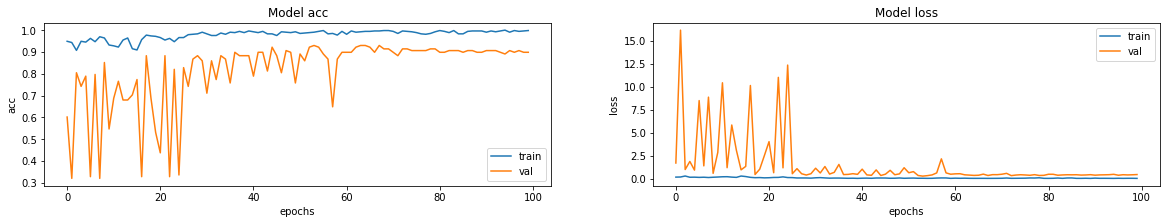

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(['acc', 'loss']):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history[f'val_{metric}'])
    ax[i].set_title(f'Model {metric}')
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(metric)
    ax[i].legend(['train', 'val'])

## Cleanup

In [ ]:
wandb.finish()

acc,▄▁▅▆▃▅▁▆▆▅▆▇▇▇▇▇█▇▆▇▇▇█▆▇███▇█▇▇████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▅█▄▄▆▅▆▃▃▄▃▂▃▂▂▁▂▂▂▂▂▁▁▂▂▁▁▁▂▁▂▃▁▁▁▁▁▁▁▁
lr,███████▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▄▇▁▁▅▅▆▇▂▁▇▇▅▇▆▇▆▇▇████▇████▇███████████
val_loss,▂▁▆▇█▅▂▁▃█▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
GFLOPS,8.98109
acc,0.99811
best_epoch,53
best_val_loss,0.27911
epoch,99


## Single CT Scan Predictions

In [ ]:
model.load_weights('best.h5')
input_volume = test_generator.__getitem__(1)[0]

prediction = model.predict(input_volume)[0]
print(prediction)

[0.13216852 0.86783147]


# Model Evaluation

In [ ]:
y_pred = [np.argmax(x) for x in model.predict(test_generator, batch_size=config['batch_size'])]
y_test = [labels[idx] for idx in test_indices]

## Classification Report

In [ ]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.833     0.926     0.877        54
           1      0.963     0.912     0.937       114

    accuracy                          0.917       168
   macro avg      0.898     0.919     0.907       168
weighted avg      0.921     0.917     0.918       168



## Confusion Matrix

<AxesSubplot:>

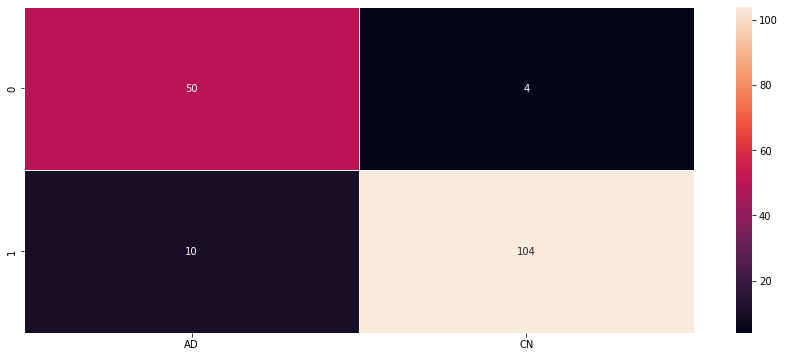

In [ ]:
cfsn_matrix = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cfsn_matrix, index=range(config['n_classes']), columns=CLASS_NAMES)
plt.figure(figsize=(15, 6))
sn.heatmap(df_cm, annot=True, linewidths=0.5, fmt='d')

# Explainable AI - Grad-CAM 3D Visualizations



In [ ]:
volume_size = input_volume.shape
last_conv_layer_name = 'add_3'

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Generate class activation heatmap"""
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = Model(
        [model.inputs], [model.get_layer(
            last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel (equivalent to global average pooling)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2, 3))

    # We multiply each channel in the feature map array
    # by 'how important this channel is' with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    # Notice that we clip the heatmap values, which is equivalent to applying ReLU
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

## Heatmap Generation

In [ ]:
# Remove last layer's activation
model.layers[-1].activation = None

# Print what the top predicted class is
input_volume = input_volume[0:1, :, :, :, :]
img_array = input_volume

preds = model.predict(img_array)
print('Predicted:', preds[0])

input_volume = np.squeeze(input_volume)
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

Predicted: [0.13216852 0.86783147]


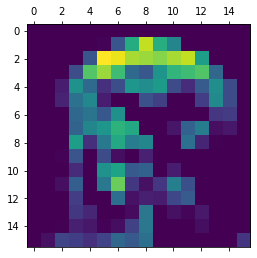

In [ ]:
plt.matshow(np.squeeze(heatmap[:, :, 1]))
plt.show()

## Expanding Heatmap Dimensions

Notice that similarly to resizing the input volume, expanding the heatmap dimensions is based on the *spline interpolated zoom*.

In [ ]:
def get_resized_heatmap(heatmap, shape):
    """Resize heatmap to shape"""
    # Rescale heatmap to a range 0-255
    upscaled_heatmap = np.uint8(255 * heatmap)

    upscaled_heatmap = zoom(
        upscaled_heatmap,
        (
            shape[0] / upscaled_heatmap.shape[0],
            shape[1] / upscaled_heatmap.shape[1],
            shape[2] / upscaled_heatmap.shape[2],
        ),
    )

    return upscaled_heatmap


resized_heatmap = get_resized_heatmap(heatmap, input_volume.shape)

# Visualizations

Now it is time for us to graphically visualize the results obtained by overlaying the heatmap with the image. We utilize the `jet` colormap for this.

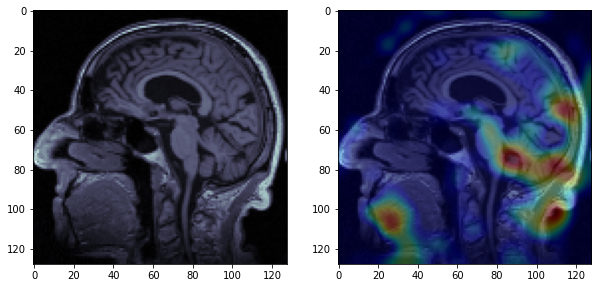

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 20))

ax[0].imshow(np.squeeze(input_volume[:, :, 30]), cmap='bone')
img0 = ax[1].imshow(np.squeeze(input_volume[:, :, 30]), cmap='bone')
img1 = ax[1].imshow(np.squeeze(resized_heatmap[:, :, 30]),
                    cmap='jet', alpha=0.3, extent=img0.get_extent())
plt.show()

In [ ]:
def get_bounding_boxes(heatmap, threshold=0.15, otsu=False):
    """Get bounding boxes from heatmap"""
    p_heatmap = np.copy(heatmap)

    if otsu:
        # Otsu's thresholding method to find the bounding boxes
        threshold, p_heatmap = cv2.threshold(
            heatmap, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
        )
    else:
        # Using a fixed threshold
        p_heatmap[p_heatmap < threshold * 255] = 0
        p_heatmap[p_heatmap >= threshold * 255] = 1

    # find the contours in the thresholded heatmap
    contours = cv2.findContours(p_heatmap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    # get the bounding boxes from the contours
    bboxes = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        bboxes.append([x, y, x + w, y + h])

    return bboxes


def get_bbox_patches(bboxes, color='r', linewidth=2):
    """Get patches for bounding boxes"""
    patches = []
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        patches.append(
            Rectangle(
                (x1, y1),
                x2 - x1,
                y2 - y1,
                edgecolor=color,
                facecolor='none',
                linewidth=linewidth,
            )
        )
    return patches

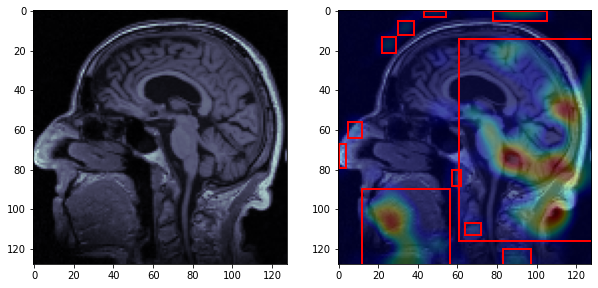

In [ ]:
# show the bounding boxes on the original image
fig, ax = plt.subplots(1, 2, figsize=(10, 20))

ax[0].imshow(np.squeeze(input_volume[:, :, 30]), cmap='bone')
img0 = ax[1].imshow(np.squeeze(input_volume[:, :, 30]), cmap='bone')
img1 = ax[1].imshow(np.squeeze(resized_heatmap[:, :, 30]),
                    cmap='jet', alpha=0.3, extent=img0.get_extent())

bboxes = get_bounding_boxes(np.squeeze(resized_heatmap[:, :, 30]))
patches = get_bbox_patches(bboxes)

for patch in patches:
    ax[1].add_patch(patch)

plt.show()